## Abstract

In this document I will show you how to use **Partial Dependence Plots** to better understand what a complex model is doing. The partial dependence plot shows the marginal effect of a feature on the predicted outcome (J. H. Friedman 2001). A partial dependence plot can show if the relationship between the target and a feature is linear, monotonic or something else. If you want to know more about partial dependence plots, look at the great [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/pdp.html) book.


I will use the [pdpbox](https://github.com/SauceCat/PDPbox) module to calculate and plot **Partial Dependence Plots**. The module supports all Scikit-Learn algorithms!

Scikit Learn has its own implementation of PDPs, but this package contains methods to create really nice plots!

## Import required modules

In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pdpbox import pdp
from sklearn.externals import joblib

In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (13, 6)

Populating the interactive namespace from numpy and matplotlib


## Load data and model 

In [3]:
model, training_set, test_set = joblib.load("../../0-model-to-explain/model_and_data_python.sav")

## Plot PDPs

Let's plot the PDPs now. We can choose to treat features individually or to combine two or three fo them to see the combined influence in the output **as the model sees it**.

### Age
Let's start by analysing how the model thinks that the age affects the probability of surviving. First of all, we have to remove rows without age:

In [4]:
age_training_set = training_set.dropna(axis = 0, subset = ['Age'], how = 'any')

The **pdpbox** module lets us plot a "real target plot" for a particular feature. This plot relates the feature with the target variable using only the dataset. Nice!

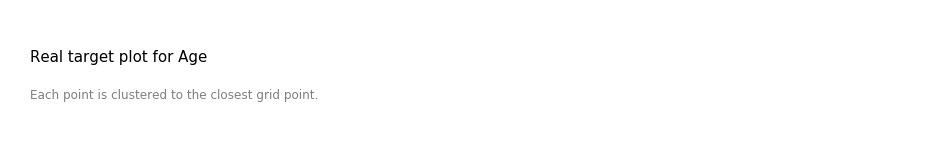

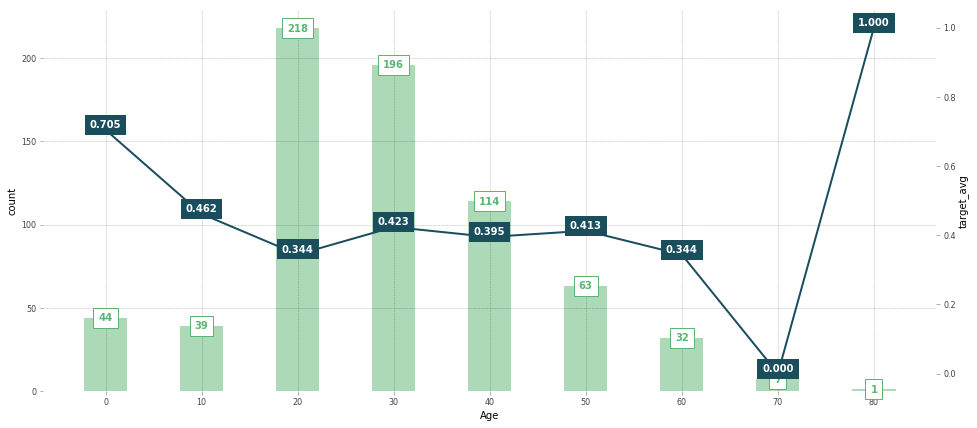

In [5]:
pdp.target_plot(df = age_training_set, feature = "Age", 
                feature_name = "Age", target= 'Survived', 
                cust_grid_points = list(range(0, 90, 10)))

This plot only shows the binned data set and the survival probability for each bin, but only considers the "Age" feature. PDPs are more trustable, as models usually take into account the effect of all variables in the output.

So let's calculate the PDP. This function also calculates the ICEs, as we will see in the ICEs notebook.

In [6]:
pdp_age = pdp.pdp_isolate(
    model = model, 
    train_X = age_training_set.drop(columns = "Survived"),
    feature = "Age",
    cust_grid_points = list(range(0,100,5))
)

In [7]:
print("PDP data:")
pdp_age.pdp
print("-----------------------------------------------------------------------------------")

PDP data:
-----------------------------------------------------------------------------------


Now we have the data and we are able to plot it our way.

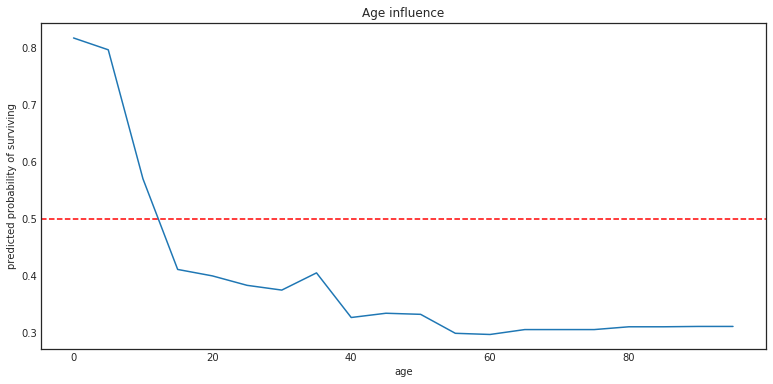

In [8]:
sns.set_style("white")
plt.axhline(y = 0.5, color = "red", linestyle = "--");
plt.plot(pdp_age.feature_grids, pdp_age.pdp);
plt.xlabel("age");
plt.ylabel("predicted probability of surviving");
plt.title("Age influence");

Well, that makes sense. According to the model, the age has a strong impact in the survival probability for children under 10. For the rest of the passengers, the older the passenger, the higher the probability of dying.

### Fare
As before, let's plot the "real target plot" to compare it with the PDP:

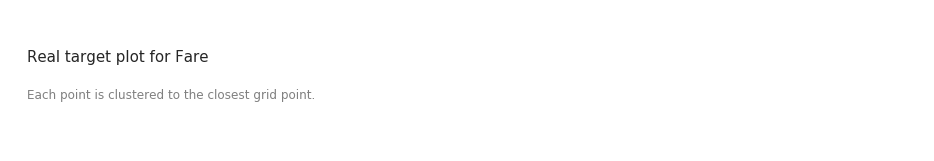

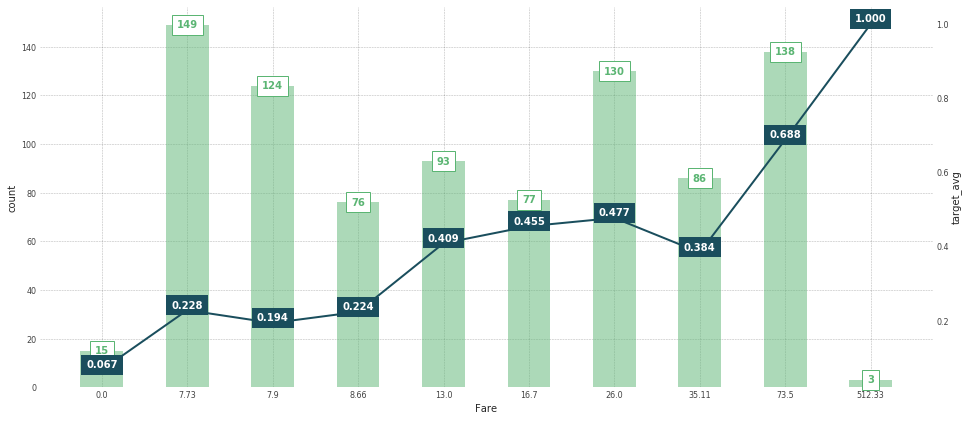

In [9]:
pdp.target_plot(df = training_set, feature = "Fare", 
                feature_name = "Fare", target= 'Survived')

It looks like passengers who paid more for their ticket had a higher survival probability. And that makes sense!

Let's now analyse how the model thinks that the fare affects the probability of surviving:

In [10]:
pdp_fare = pdp.pdp_isolate(
    model = model, 
    train_X = age_training_set.drop(columns = "Survived"),
    feature = "Fare", 
    num_grid_points = 15
)

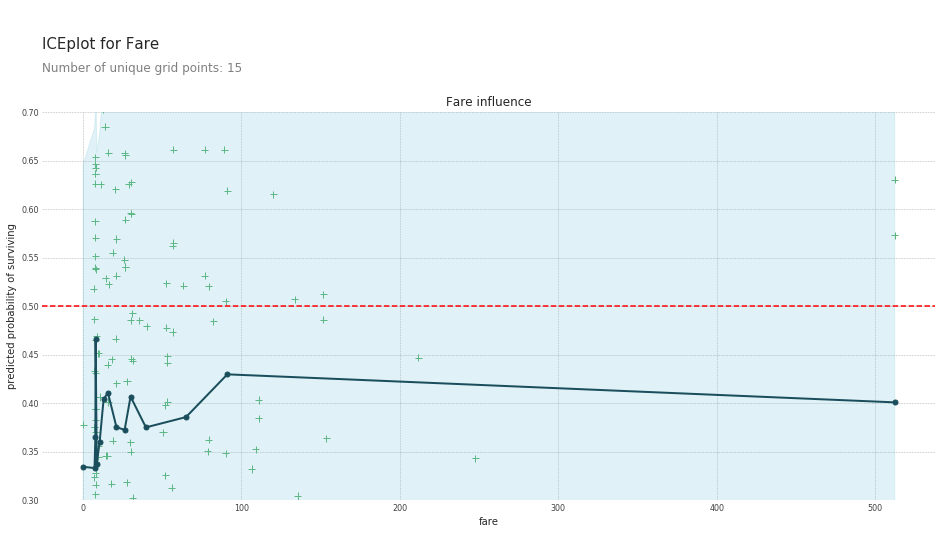

In [11]:
pdp.pdp_plot(pdp_isolate_out = pdp_fare, feature_name = 'Fare', 
             plot_org_pts = True, center = False)
plt.ylim(0.3,0.7);
plt.axhline(y = 0.5, color = "red", linestyle = "--");
plt.xlabel("fare");
plt.ylabel("predicted probability of surviving");
plt.title("Fare influence");

The model thinks that the contribution of "Fare" is not so important. And this also makes sense, because other variables, like "Pclass", are probably more important and are highly correlated with "Fare".

The influence of the fare between 0 and 120 is noisy, but makes sense. The more you pay, the more probable it is that you survive (we all know what happened). Above 120, it looks that we do not have enough data:

In [12]:
training_set.loc[training_set.Fare > 120].shape[0]

38

## Sex

Let's try to do the same with a cathegorical variable:

In [13]:
pdp_sex = pdp.pdp_isolate(
    model = model, 
    train_X = age_training_set.drop(columns = "Survived"),
    feature = "Sex", 
    num_grid_points = 15
)

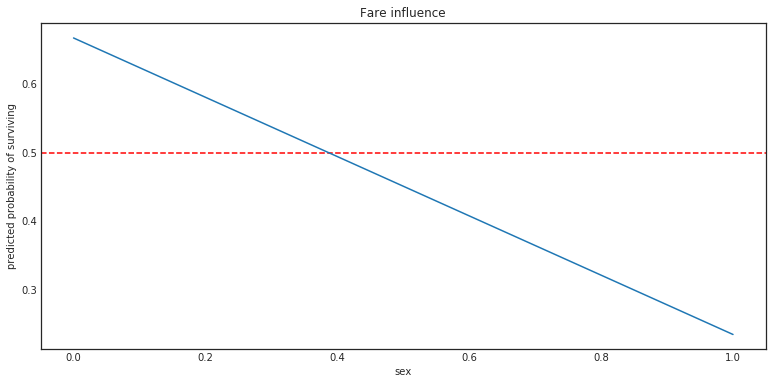

In [14]:
sns.set_style("white")
plt.axhline(y = 0.5, color = "red", linestyle = "--");
plt.plot(pdp_sex.feature_grids, pdp_sex.pdp);
plt.xlabel("sex");
plt.ylabel("predicted probability of surviving");
plt.title("Fare influence");

We can clearly see the global trend affecting sex.

### One hot encoded variable
One interesting thing of this package is that is lets us plot PDPs for one-hot-encoded variables. Let's see the results with the Embarked feature.

First of all, we will plot the "Real target plot", based only in our dataset:

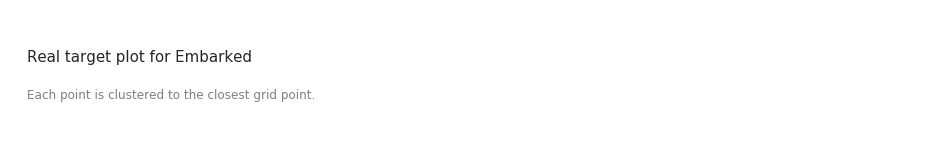

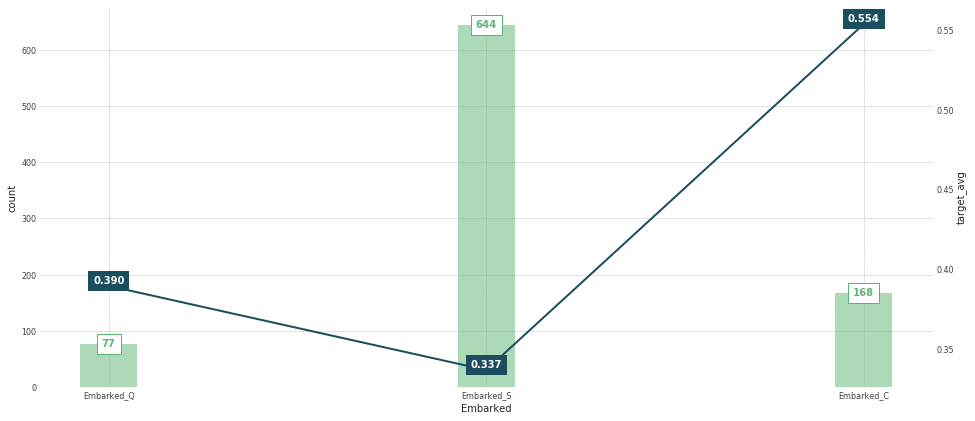

In [15]:
pdp.target_plot(
    df = training_set, 
    feature = ["Embarked_Q", "Embarked_S", "Embarked_C"],
    feature_name = "Embarked",
    target = "Survived"
)

The plot shows the number of passengers that embarked in each port and the probability of surviving for each of them.

Let's see how the model sees it:

In [16]:
pdp_embarked = pdp.pdp_isolate(model = model, 
                               train_X = training_set.drop(columns = "Survived"),
                               feature = ["Embarked_Q", "Embarked_S", "Embarked_C"])

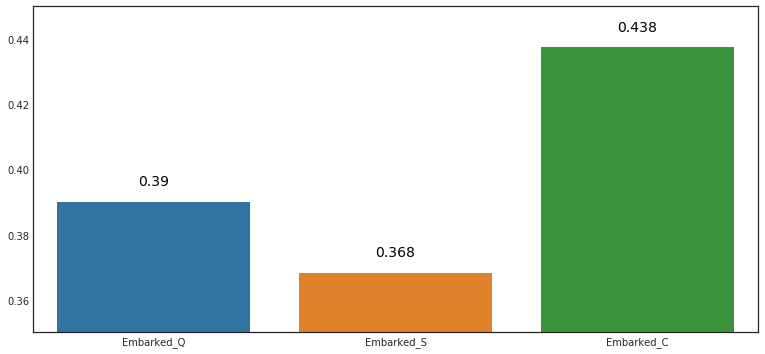

In [17]:
axis = sns.barplot(x = pdp_embarked.feature_grids, y = pdp_embarked.pdp)
_ = plt.ylim(0.35,0.45)
for i in range(3):
    _ = axis.text(x = i, y = pdp_embarked.pdp[i] + 0.005, 
                  s = "{0:.3}".format(pdp_embarked.pdp[i]),
                  color='black', ha="center", fontsize = 14)

As we can see, the model captures the trend, but gives less importance to the embarked feature than the raw data. That's because the model considers the contribution of all the other features in the final prediction, so this result is more trustable than the result above.

We can also visualize the actual predictions:

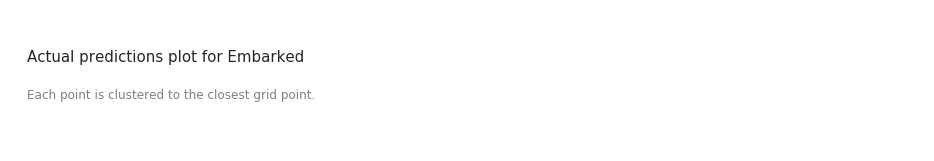

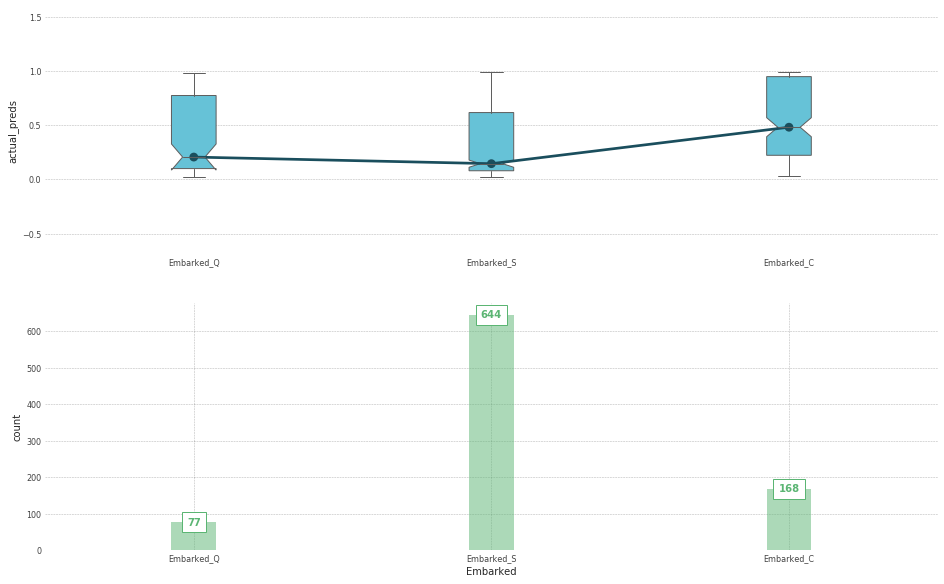

In [18]:
pdp.actual_plot(pdp_isolate_out = pdp_embarked, feature_name = "Embarked")

## Multiple variables

What if we want to see how two features interact with each other and with our target variable according to the model? We can plot a 2D heat map like this:

In [19]:
age_fare_interaction = pdp.pdp_interact(model = model, 
                                        train_X = age_training_set.drop(columns = "Survived"), 
                                        features = ["Age", "Fare"])

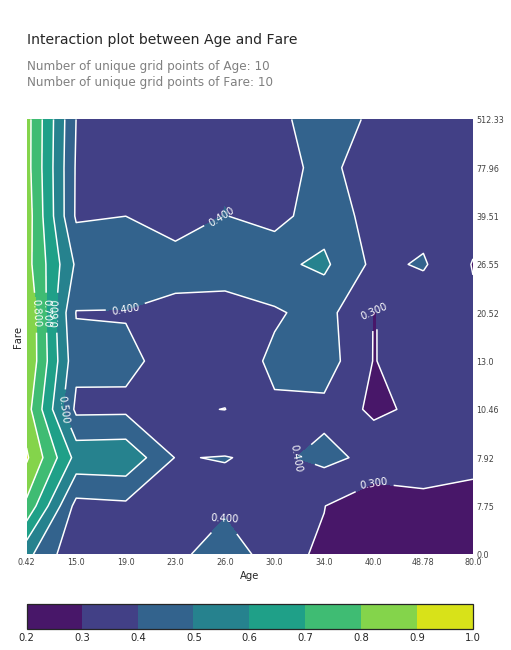

In [20]:
pdp.pdp_interact_plot(pdp_interact_out = age_fare_interaction, 
                      feature_names = ["Age", "Fare"], x_quantile = True, 
                      only_inter = True)

So old poor people die, children survive, and there is a strange subset with higher survival probability arounf Fare == 26.55. It would be interesting to study why.

The plot works much better using quantiles to set the ticks. Withou quantiles, it is something like:

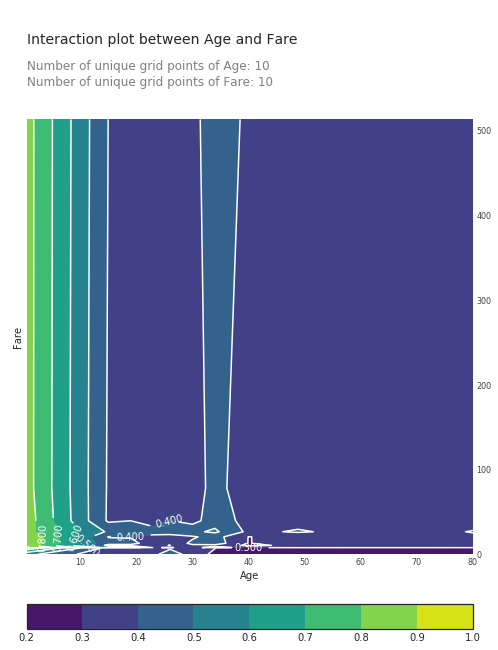

In [21]:
pdp.pdp_interact_plot(pdp_interact_out = age_fare_interaction, 
                      feature_names = ["Age", "Fare"], x_quantile = False, 
                      only_inter = True)

We are showing big areas that do not contain data, so the resulting plot is worse.

To finish, let's see the interaction between age and Pclass_3:

In [22]:
age_pclass_interaction = pdp.pdp_interact(model = model, 
                                          train_X = age_training_set.drop(columns = "Survived"), 
                                          features = ["Age", "Pclass_3"])

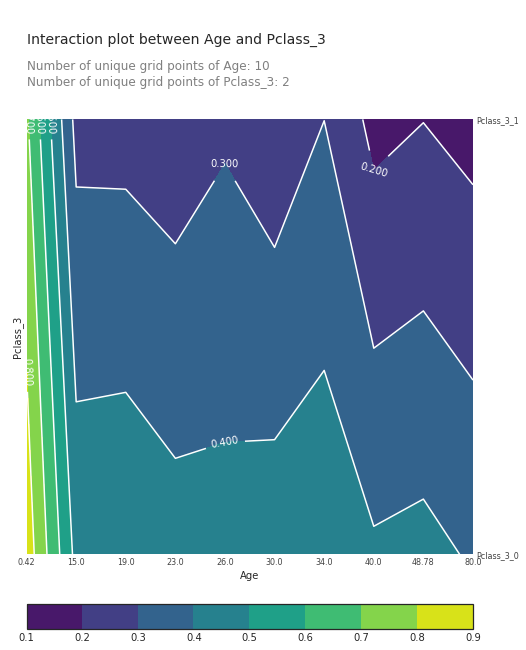

In [23]:
pdp.pdp_interact_plot(pdp_interact_out = age_pclass_interaction, 
                      feature_names = ["Age", "Pclass_3"], x_quantile=True, 
                      only_inter=True)

And the interaction between Sex and Pclass_3:

In [24]:
sex_pclass_interaction = pdp.pdp_interact(model = model, 
                                          train_X = age_training_set.drop(columns = "Survived"), 
                                          features = ["Sex", "Pclass_3"])

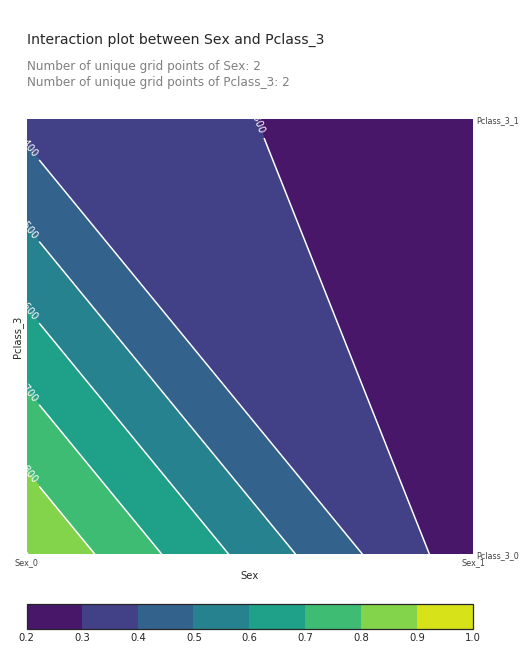

In [25]:
pdp.pdp_interact_plot(pdp_interact_out = sex_pclass_interaction, 
                      feature_names = ["Sex", "Pclass_3"], x_quantile=True, 
                      only_inter=True)

Quite clear :)

It is difficult to create a plot better than this one to show how the model thinks that Sex and Pclass_3 influence the survival probabilities.